### Total Profit

In [14]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict


results_dir = "../results"
dataset_dir = "../dataset"


def rename_model(model_name):
    model_name = model_name.replace("seller_", "")
    model_name = model_name.replace("deepseek-reasoner", "DeepSeek-R1")
    model_name = model_name.replace("deepseek-chat", "DeepSeek-V3")
    model_name = model_name.replace("gpt-4o-mini", "GPT-4o-mini")
    model_name = model_name.replace("gpt-3.5-turbo", "GPT-3.5-Turbo")
    model_name = model_name.replace("qwen", "Qwen").replace("-instruct", "")
    model_name = model_name.replace("gpt-4.1", "GPT-4.1")
    return model_name


def load_products():
    with open(os.path.join(dataset_dir, "products_mini.json"), 'r', encoding='utf-8') as f:
        products = json.load(f)
    
    product_info = {}
    for product in products:
        product_id = product.get("id")
        product_type = product.get("Type")
        wholesale_price = float(product.get("Wholesale Price", "0").replace("$", "").replace(",", ""))
        retail_price = float(product.get("Retail Price", "0").replace("$", "").replace(",", ""))
        
        product_info[product_id] = {
            'type': product_type,
            'wholesale_price': wholesale_price,
            'retail_price': retail_price
        }
    
    return product_info


def analyze_deal_rates_and_profits():
    product_info = load_products()
    budget_types = ['low', 'wholesale', 'mid', 'retail', 'high']
    
    stats = defaultdict(lambda: defaultdict(lambda: {
        'total': 0, 
        'success': 0, 
        'profits': [], 
        'success_products': [],
        'average_price': [],
        'price_to_wholesale_ratio': []
    }))
    
    for seller_dir in os.listdir(results_dir):
        if not seller_dir.startswith("seller_"):
            continue
            
        seller_model = rename_model(seller_dir)
        seller_path = os.path.join(results_dir, seller_dir)
        
        for buyer_dir in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_dir)
            
            for product_dir in os.listdir(buyer_path):
                if not product_dir.startswith("product_"):
                    continue
                
                try:
                    product_id = int(product_dir.replace("product_", ""))
                except ValueError:
                    continue
                
                prod_info = product_info.get(product_id, {})
                wholesale_price = prod_info.get('wholesale_price', 0)
                product_type = prod_info.get('type', 'Unknown')
                
                product_path = os.path.join(buyer_path, product_dir)
                
                for budget_dir in os.listdir(product_path):
                    if not budget_dir.startswith("budget_"):
                        continue
                        
                    budget_type = budget_dir.replace("budget_", "")
                    
                    if budget_type not in budget_types:
                        continue
                        
                    budget_path = os.path.join(product_path, budget_dir)
                    
                    for result_file in os.listdir(budget_path):
                        if not result_file.endswith(".json"):
                            continue
                            
                        result_path = os.path.join(budget_path, result_file)
                        
                        try:
                            with open(result_path, 'r', encoding='utf-8') as f:
                                data = json.load(f)
                            
                            stats[seller_model][budget_type]['total'] += 1
                            
                            price_offers = data.get("seller_price_offers", [])
                            
                            if data.get("negotiation_result") == "accepted" and not data.get("out_of_budget", True):
                                stats[seller_model][budget_type]['success'] += 1
                                
                                if price_offers and len(price_offers) > 0:
                                    final_price = price_offers[-1]
                                    profit = final_price - wholesale_price
                                    
                                    stats[seller_model][budget_type]['profits'].append(profit)
                                    stats[seller_model][budget_type]['success_products'].append(product_type)
                                    stats[seller_model][budget_type]['average_price'].append(final_price)
                                    if wholesale_price > 0:
                                        stats[seller_model][budget_type]['price_to_wholesale_ratio'].append(final_price / wholesale_price)
                            
                        except Exception as e:
                            print(f"Error processing {result_path}: {e}")
    
    return stats, budget_types


def prepare_analysis_data(stats, budget_types):
    deal_rate_data = []
    profit_data = []
    comprehensive_data = []
    
    for model, budget_stats in stats.items():
        model_total = 0
        model_success = 0
        model_all_profits = []
        model_all_products = []
        model_all_prices = []
        model_all_ratios = []
        
        for budget_type in budget_types:
            budget_stats_obj = budget_stats.get(budget_type, {
                'total': 0, 
                'success': 0, 
                'profits': [], 
                'success_products': [],
                'average_price': [],
                'price_to_wholesale_ratio': []
            })
            
            total = budget_stats_obj['total']
            success = budget_stats_obj['success']
            profits = budget_stats_obj['profits']
            products = budget_stats_obj['success_products']
            prices = budget_stats_obj['average_price']
            ratios = budget_stats_obj['price_to_wholesale_ratio']
            
            model_total += total
            model_success += success
            model_all_profits.extend(profits)
            model_all_products.extend(products)
            model_all_prices.extend(prices)
            model_all_ratios.extend(ratios)
            
            rate = success / total if total > 0 else 0
            avg_profit = np.mean(profits) if profits else 0
            avg_price = np.mean(prices) if prices else 0
            avg_ratio = np.mean(ratios) if ratios else 0
            
            deal_rate_data.append({
                'Model': model,
                'Budget': budget_type,
                'Deal_Rate': rate,
                'Total': total,
                'Success': success
            })
            
            profit_data.append({
                'Model': model,
                'Budget': budget_type,
                'Average_Profit': avg_profit,
                'Profit_Count': len(profits)
            })
            
            comprehensive_data.append({
                'Model': model,
                'Budget': budget_type,
                'Deal_Rate': rate,
                'Average_Profit': avg_profit,
                'Average_Price': avg_price,
                'Price_to_Wholesale_Ratio': avg_ratio,
                'Total_Cases': total,
                'Success_Cases': success,
                'Vehicle_Count': products.count('Vehicle'),
                'Electronics_Count': products.count('Electronics'),
                'Real_Estate_Count': products.count('Real Estate')
            })
        
        overall_rate = model_success / model_total if model_total > 0 else 0
        overall_avg_profit = np.mean(model_all_profits) if model_all_profits else 0
        overall_avg_price = np.mean(model_all_prices) if model_all_prices else 0
        overall_avg_ratio = np.mean(model_all_ratios) if model_all_ratios else 0
        
        deal_rate_data.append({
            'Model': model,
            'Budget': 'Overall',
            'Deal_Rate': overall_rate,
            'Total': model_total,
            'Success': model_success
        })
        
        profit_data.append({
            'Model': model,
            'Budget': 'Overall',
            'Average_Profit': overall_avg_profit,
            'Profit_Count': len(model_all_profits)
        })
        
        comprehensive_data.append({
            'Model': model,
            'Budget': 'Overall',
            'Deal_Rate': overall_rate,
            'Average_Profit': overall_avg_profit,
            'Average_Price': overall_avg_price,
            'Price_to_Wholesale_Ratio': overall_avg_ratio,
            'Total_Cases': model_total,
            'Success_Cases': model_success,
            'Vehicle_Count': model_all_products.count('Vehicle'),
            'Electronics_Count': model_all_products.count('Electronics'),
            'Real_Estate_Count': model_all_products.count('Real Estate')
        })
    
    deal_rate_df = pd.DataFrame(deal_rate_data)
    profit_df = pd.DataFrame(profit_data)
    comprehensive_df = pd.DataFrame(comprehensive_data)
    
    return deal_rate_df, profit_df, comprehensive_df

# 复用你的 analyze_deal_rates_and_profits 函数，但只关注收益部分
def calculate_total_profits():
    product_info = load_products()
    model_profits = defaultdict(lambda: {
        'total_profit': 0,
        'total_deals': 0,
        'product_type_profits': defaultdict(float),
        'product_type_counts': defaultdict(int)
    })
    
    for seller_dir in os.listdir(results_dir):
        if not seller_dir.startswith("seller_"):
            continue
            
        seller_model = rename_model(seller_dir)
        seller_path = os.path.join(results_dir, seller_dir)
        
        for buyer_dir in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_dir)
            
            for product_dir in os.listdir(buyer_path):
                if not product_dir.startswith("product_"):
                    continue
                
                try:
                    product_id = int(product_dir.replace("product_", ""))
                except ValueError:
                    continue
                
                prod_info = product_info.get(product_id, {})
                wholesale_price = prod_info.get('wholesale_price', 0)
                product_type = prod_info.get('type', 'Unknown')
                
                product_path = os.path.join(buyer_path, product_dir)
                
                for budget_dir in os.listdir(product_path):
                    if not budget_dir.startswith("budget_"):
                        continue
                        
                    budget_path = os.path.join(product_path, budget_dir)
                    
                    for result_file in os.listdir(budget_path):
                        if not result_file.endswith(".json"):
                            continue
                            
                        result_path = os.path.join(budget_path, result_file)
                        
                        try:
                            with open(result_path, 'r', encoding='utf-8') as f:
                                data = json.load(f)
                            
                            if data.get("negotiation_result") == "accepted" and not data.get("out_of_budget", True):
                                price_offers = data.get("seller_price_offers", [])
                                if price_offers:
                                    final_price = price_offers[-1]
                                    profit = final_price - wholesale_price
                                    
                                    model_profits[seller_model]['total_profit'] += profit
                                    model_profits[seller_model]['total_deals'] += 1
                                    model_profits[seller_model]['product_type_profits'][product_type] += profit
                                    model_profits[seller_model]['product_type_counts'][product_type] += 1
                            
                        except Exception as e:
                            print(f"Error processing {result_path}: {e}")
    
    # 打印结果
    print("\nTotal Profits Analysis by Model:")
    print("-" * 80)
    for model, stats in model_profits.items():
        print(f"\nModel: {model}")
        print(f"Total Profit: ${stats['total_profit']:,.2f}")
        print(f"Total Successful Deals: {stats['total_deals']}")
        print(f"Average Profit per Deal: ${stats['total_profit']/stats['total_deals']:,.2f}" if stats['total_deals'] > 0 else "No successful deals")
        
        print("\nProfit by Product Type:")
        for product_type, profit in stats['product_type_profits'].items():
            count = stats['product_type_counts'][product_type]
            avg_profit = profit / count if count > 0 else 0
            print(f"  {product_type}:")
            print(f"    Total Profit: ${profit:,.2f}")
            print(f"    Number of Deals: {count}")
            print(f"    Average Profit per Deal: ${avg_profit:,.2f}")
        print("-" * 80)

def analyze_deal_rate_profit_correlation(comprehensive_df):
    overall_data = comprehensive_df[comprehensive_df['Budget'] == 'Overall']
    
    sorted_by_rate = overall_data.sort_values('Deal_Rate')
    print("\nModels Sorted by Deal Rate (Lowest to Highest):")
    for _, row in sorted_by_rate.iterrows():
        print(f"{row['Model']}: Deal Rate = {row['Deal_Rate']:.4f}, Avg Profit = {row['Average_Profit']:.2f}, " 
              f"Avg Price = {row['Average_Price']:.2f}, Price/Wholesale Ratio = {row['Price_to_Wholesale_Ratio']:.4f}")
        print(f"  Vehicle: {row['Vehicle_Count']}, Electronics: {row['Electronics_Count']}, Real Estate: {row['Real_Estate_Count']}")
    
    sorted_by_profit = overall_data.sort_values('Average_Profit')
    print("\nModels Sorted by Average Profit (Lowest to Highest):")
    for _, row in sorted_by_profit.iterrows():
        print(f"{row['Model']}: Avg Profit = {row['Average_Profit']:.2f}, Deal Rate = {row['Deal_Rate']:.4f}, " 
              f"Avg Price = {row['Average_Price']:.2f}, Price/Wholesale Ratio = {row['Price_to_Wholesale_Ratio']:.4f}")
        print(f"  Vehicle: {row['Vehicle_Count']}, Electronics: {row['Electronics_Count']}, Real Estate: {row['Real_Estate_Count']}")
    
    print("\nProduct Type Distribution in Successful Deals:")
    for _, row in overall_data.iterrows():
        total_products = row['Vehicle_Count'] + row['Electronics_Count'] + row['Real_Estate_Count']
        if total_products > 0:
            vehicle_pct = row['Vehicle_Count'] / total_products * 100
            electronics_pct = row['Electronics_Count'] / total_products * 100
            real_estate_pct = row['Real_Estate_Count'] / total_products * 100
            
            print(f"{row['Model']}: Vehicle = {vehicle_pct:.1f}%, Electronics = {electronics_pct:.1f}%, "
                  f"Real Estate = {real_estate_pct:.1f}%")
    
    gpt4o_data = comprehensive_df[comprehensive_df['Model'] == 'GPT-4o-mini']
    
    if not gpt4o_data.empty:
        print("\nDetailed Analysis for GPT-4o-mini:")
        for _, row in gpt4o_data.iterrows():
            print(f"Budget: {row['Budget']}")
            print(f"  Deal Rate: {row['Deal_Rate']:.4f}")
            print(f"  Average Profit: {row['Average_Profit']:.2f}")
            print(f"  Average Price: {row['Average_Price']:.2f}")
            print(f"  Price/Wholesale Ratio: {row['Price_to_Wholesale_Ratio']:.4f}")
            total_products = row['Vehicle_Count'] + row['Electronics_Count'] + row['Real_Estate_Count']
            if total_products > 0:
                print(f"  Products: Vehicle = {row['Vehicle_Count']} ({row['Vehicle_Count']/total_products*100:.1f}%), "
                      f"Electronics = {row['Electronics_Count']} ({row['Electronics_Count']/total_products*100:.1f}%), "
                      f"Real Estate = {row['Real_Estate_Count']} ({row['Real_Estate_Count']/total_products*100:.1f}%)")

if __name__ == "__main__":
    print("Analyzing deal rates and profits...")
    stats, budget_types = analyze_deal_rates_and_profits()
    
    print("Preparing analysis data...")
    deal_rate_df, profit_df, comprehensive_df = prepare_analysis_data(stats, budget_types)
    
    print("Analyzing correlation between deal rate and profit...")
    analyze_deal_rate_profit_correlation(comprehensive_df)

    print("Calculating total profits for each model...")
    calculate_total_profits()
    print("Done!")
    
    print("Done!")

Analyzing deal rates and profits...
Preparing analysis data...
Analyzing correlation between deal rate and profit...

Models Sorted by Deal Rate (Lowest to Highest):
GPT-4o-mini: Deal Rate = 0.3349, Avg Profit = 148659.17, Avg Price = 1175630.22, Price/Wholesale Ratio = 1.2535
  Vehicle: 358, Electronics: 239, Real Estate: 278
o3: Deal Rate = 0.3738, Avg Profit = 174138.89, Avg Price = 1144836.91, Price/Wholesale Ratio = 1.2183
  Vehicle: 337, Electronics: 248, Real Estate: 247
DeepSeek-V3: Deal Rate = 0.3760, Avg Profit = 127268.82, Avg Price = 1011869.41, Price/Wholesale Ratio = 1.1895
  Vehicle: 397, Electronics: 282, Real Estate: 255
GPT-4.1: Deal Rate = 0.3868, Avg Profit = 147083.90, Avg Price = 1285532.30, Price/Wholesale Ratio = 1.1762
  Vehicle: 508, Electronics: 342, Real Estate: 431
o4-mini: Deal Rate = 0.4480, Avg Profit = 103500.76, Avg Price = 831562.93, Price/Wholesale Ratio = 1.1821
  Vehicle: 625, Electronics: 501, Real Estate: 308
DeepSeek-R1: Deal Rate = 0.5087, Avg 

C:\Users\zhush\AppData\Local\Temp\ipykernel_34328\1713268021.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buyer_row = summary_df[summary_df['model_name'] == model][summary_df['role'] == 'Buyer']
C:\Users\zhush\AppData\Local\Temp\ipykernel_34328\1713268021.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seller_row = summary_df[summary_df['model_name'] == model][summary_df['role'] == 'Seller']


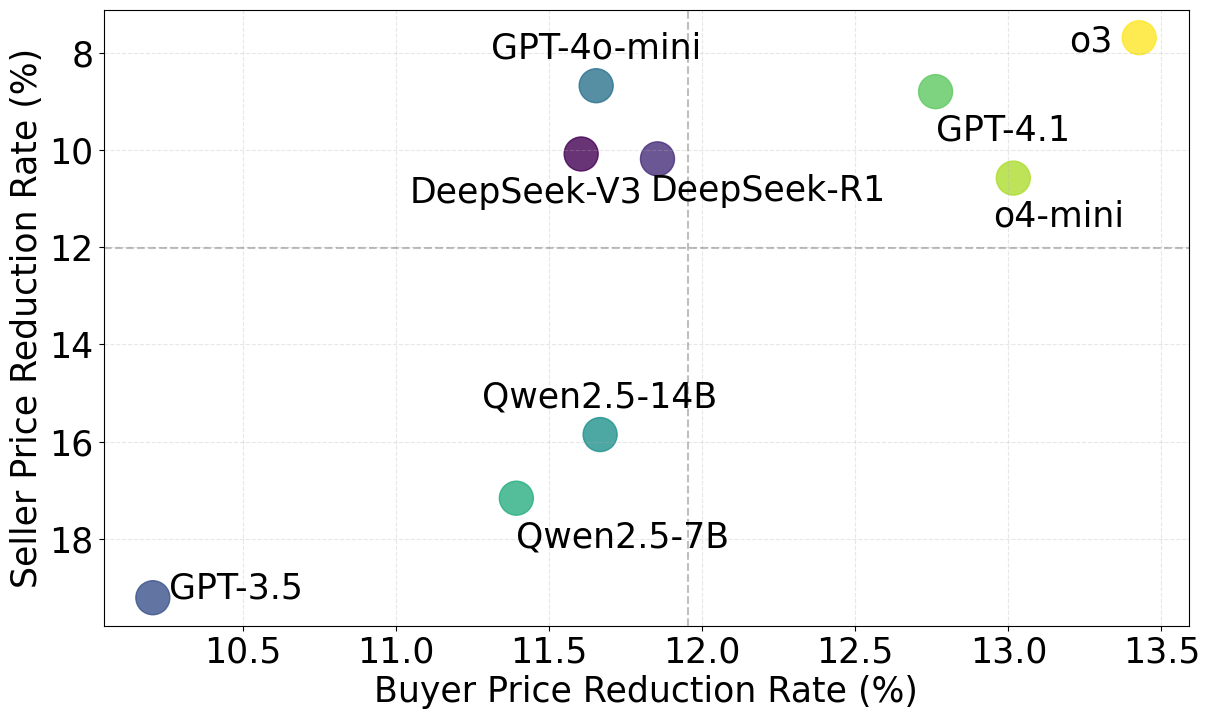


Summary statistics for all budgets:
     model_name    role  price_reduction
0   DeepSeek-R1   Buyer         0.118536
1   DeepSeek-R1  Seller         0.101833
2   DeepSeek-V3   Buyer         0.116043
3   DeepSeek-V3  Seller         0.100835
4       GPT-3.5   Buyer         0.102049
5       GPT-3.5  Seller         0.192118
6       GPT-4.1   Buyer         0.127620
7       GPT-4.1  Seller         0.088011
8   GPT-4o-mini   Buyer         0.116532
9   GPT-4o-mini  Seller         0.086791
10  Qwen2.5-14B   Buyer         0.116661
11  Qwen2.5-14B  Seller         0.158553
12   Qwen2.5-7B   Buyer         0.113925
13   Qwen2.5-7B  Seller         0.171642
14           o3   Buyer         0.134273
15           o3  Seller         0.076919
16      o4-mini   Buyer         0.130159
17      o4-mini  Seller         0.105793

Mean values:
Buyer mean: 11.95%
Seller mean: 12.03%


In [17]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def rename_model(model_name):
    model_name = model_name.replace("seller_", "")
    model_name = model_name.replace("deepseek-reasoner", "DeepSeek-R1")
    model_name = model_name.replace("deepseek-chat", "DeepSeek-V3")
    model_name = model_name.replace("gpt-4o-mini", "GPT-4o-mini")
    model_name = model_name.replace("gpt-3.5-turbo", "GPT-3.5")
    model_name = model_name.replace("qwen2.5-14b-instruct", "Qwen2.5-14B")
    model_name = model_name.replace("qwen2.5-7b-instruct", "Qwen2.5-7B")
    model_name = model_name.replace("gpt-4.1", "GPT-4.1")
    return model_name

plt.style.use('default')

base_dir = "../results"
data = []

# Traverse directories to read JSON files, process data for all budgets
for root, dirs, files in os.walk(base_dir):
    if "budget_" in root:  # Match all budget directories
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        json_data = json.load(f)
                    
                    if ("bargaining_rate" in json_data and 
                        "models" in json_data and 
                        "budget_scenario" in json_data):
                        seller_model = json_data["models"]["seller"]
                        buyer_model = json_data["models"]["buyer"]
                        bargaining_rate = json_data["bargaining_rate"]
                        budget_scenario = json_data["budget_scenario"]
                        
                        data.append({
                            'model_name': rename_model(seller_model),
                            'role': 'Seller',
                            'price_reduction': bargaining_rate,
                            'budget': budget_scenario
                        })

                        data.append({
                            'model_name': rename_model(buyer_model),
                            'role': 'Buyer',
                            'price_reduction': bargaining_rate,
                            'budget': budget_scenario
                        })
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Convert to DataFrame
df = pd.DataFrame(data)

# First calculate means by model_name, role, and budget
budget_means = df.groupby(['model_name', 'role', 'budget'])['price_reduction'].mean().reset_index()

# Then calculate overall means across all budget scenarios
summary_df = budget_means.groupby(['model_name', 'role'])['price_reduction'].mean().reset_index()

# Create scatter plot data
scatter_data = []
desired_order = ['DeepSeek-V3', 'DeepSeek-R1', 'GPT-3.5', 'GPT-4o-mini', 'Qwen2.5-14B', 'Qwen2.5-7B', "GPT-4.1", "o4-mini", "o3"]
for model in desired_order:
    buyer_row = summary_df[summary_df['model_name'] == model][summary_df['role'] == 'Buyer']
    seller_row = summary_df[summary_df['model_name'] == model][summary_df['role'] == 'Seller']

    if not buyer_row.empty and not seller_row.empty:
        scatter_data.append({
            'Model': model,
            'Buyer_PR': buyer_row['price_reduction'].values[0],
            'Seller_PR': seller_row['price_reduction'].values[0]
        })

scatter_df = pd.DataFrame(scatter_data)

# Create scatter plot
plt.figure(figsize=(14, 8))
scatter = plt.scatter(scatter_df['Buyer_PR'] * 100, scatter_df['Seller_PR'] * 100, 
                     s=600, c=range(len(scatter_df)), cmap='viridis', alpha=0.8)

# Calculate means
buyer_mean = scatter_df['Buyer_PR'].mean() * 100
seller_mean = scatter_df['Seller_PR'].mean() * 100

# Add mean reference lines
plt.axvline(x=buyer_mean, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=seller_mean, color='gray', linestyle='--', alpha=0.5)

# Add labels
for i, row in scatter_df.iterrows():
    x = row['Buyer_PR'] * 100
    y = row['Seller_PR'] * 100
    
    # Adjust label positions
    xytext = (80, -35) if x > 13 else (0, -35)
    ha = 'right' if x > 13 else 'left'

    if "14B" in row['Model']:
        xytext = (0, 20)
        ha = 'center'
    if "V3" in row['Model']:
        xytext = (-40, -35)
        ha = 'center'
    if "3.5" in row['Model']:
        xytext = (60,0)
        ha = 'center'
    if "R1" in row['Model']:
        xytext = (80,-30)
        ha = 'center'
    if "o3" in row['Model']:
        xytext = (-35, -10)
        ha = 'center'
    if "4o-mini" in row['Model']:
        xytext = (0, 20)
        ha = 'center'

    plt.annotate(row['Model'], 
                 (x, y),
                 fontsize=25, 
                 xytext=xytext,
                 textcoords='offset points',
                 ha=ha)

# Invert y-axis
plt.gca().invert_yaxis()

# Add grid and labels
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlabel('Buyer Price Reduction Rate (%)', fontsize=25)
plt.ylabel('Seller Price Reduction Rate (%)', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Save path
save_dir = '../figures'
os.makedirs(save_dir, exist_ok=True)

# Save figure
plt.savefig(f'{save_dir}/negotiation_deal_rate_scatter_all_budgets_no_error.svg', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\nSummary statistics for all budgets:")
print(summary_df)
print("\nMean values:")
print(f"Buyer mean: {buyer_mean:.2f}%")
print(f"Seller mean: {seller_mean:.2f}%")

Analyzing deal rates and profits...
Preparing analysis data...


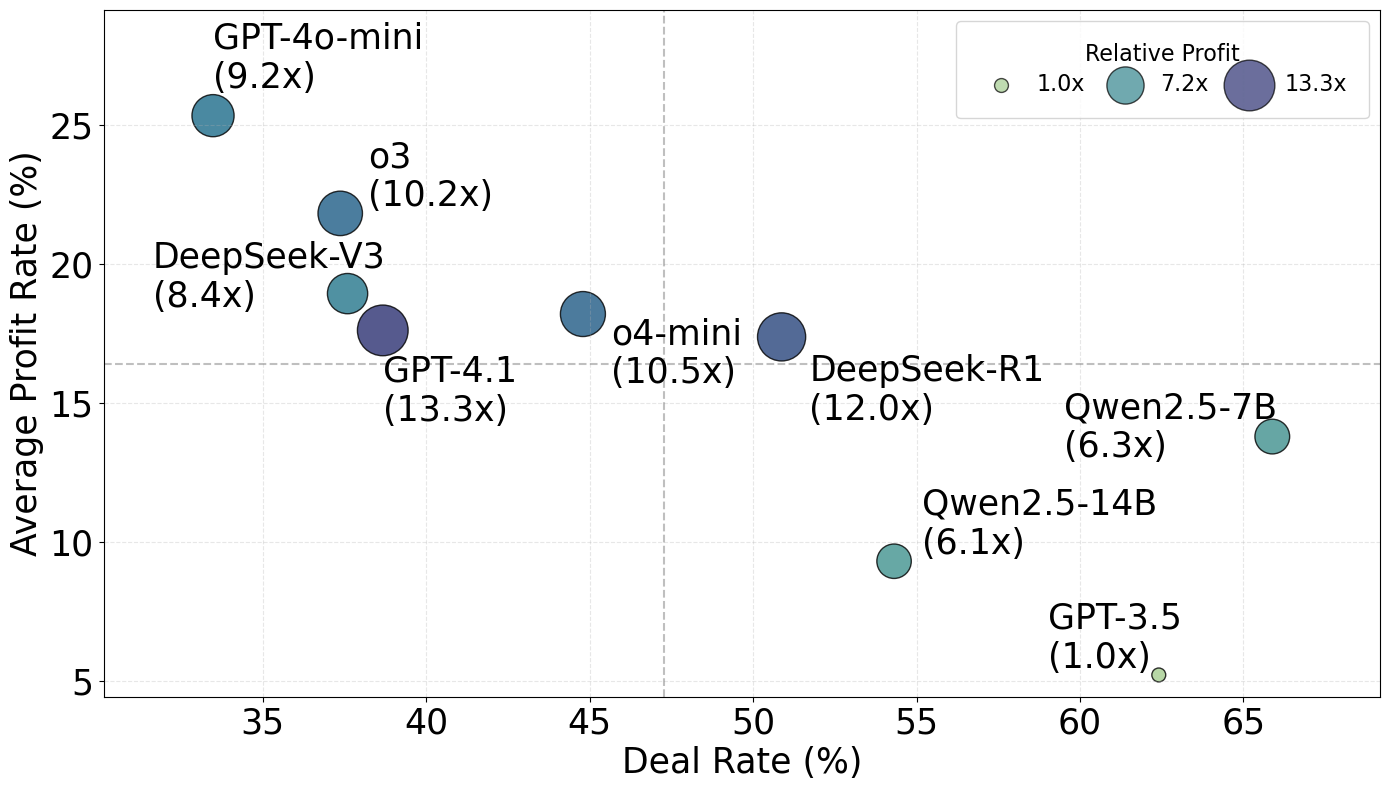

Figure 1: Deal Rate vs Profit Ratio plot created.
All figures created successfully.


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from collections import defaultdict
import seaborn as sns
def replace_model_names(df, column='Model'):
    display_names = {
        "deepseek-reasoner": "DeepSeek-R1",
        "deepseek-chat": "DeepSeek-V3",
        "gpt-4o-mini": "GPT-4o-mini",
        "gpt-3.5-turbo": "GPT-3.5",
        "qwen2.5-7b-instruct": "Qwen2.5-7B",
        "qwen2.5-14b-instruct": "Qwen2.5-14B",
        "gpt-4.1": "GPT-4.1"
    }
    df[column] = df[column].map(display_names).fillna(df[column])
    return df


# Calculate and plot scatter plot of deal rate vs average profit ratio
def plot_deal_rate_vs_profit_ratio(comprehensive_df):
    # Filter overall data
    overall_data = comprehensive_df[comprehensive_df['Budget'] == 'Overall'].copy()
    
    # Create figure - 增加了图表高度
    plt.figure(figsize=(14, 8))
    
    # 修改收益率计算方式
    # 1. 计算每个模型的总收益（包括成功和失败交易）
    total_profits = {}
    total_attempts = {}
    avg_profit_rate = {}
    for model in overall_data['Model'].unique():
        model_data = comprehensive_df[comprehensive_df['Model'] == model]
        total_profit = 0
        total_ratios = []
        total_attempts[model] = 0
        avg_profit_rate[model] = 0
        for _, row in model_data.iterrows():
            if row['Budget'] != 'Overall':  # Exclude overall data
                # 计算该预算类型下的总收益
                budget_profit = row['Average_Profit'] * row['Success_Cases']
                # 计算该预算类型下的总尝试次数
                budget_attempts = row['Success_Cases']
                total_profit += budget_profit
                total_attempts[model] += budget_attempts
                if row['Success_Cases'] > 0:
                    ratio = row['Price_to_Wholesale_Ratio']
                    # 将这个ratio重复success_cases次添加到列表中
                    total_ratios.extend([ratio] * row['Success_Cases'])

        total_profits[model] = total_profit
        profit_rate = sum([(ratio - 1) for ratio in total_ratios]) / total_attempts[model] * 100
        avg_profit_rate[model] = profit_rate # 转成百分比
    
    # 2. 计算每个模型的平均收益率（考虑所有尝试）
    overall_data['Avg_Profit_Rate'] = overall_data['Model'].map(avg_profit_rate)
    # Extract deal rate and profit ratio data, convert to percentage
    x = overall_data['Deal_Rate'] * 100  # Convert to percentage
    y = overall_data['Avg_Profit_Rate']  # 使用新的收益率计算
    
    # Add total profit to overall_data
    overall_data['Total_Profit'] = overall_data['Model'].map(total_profits)
    
    # Find minimum total profit
    min_profit = overall_data['Total_Profit'].min()
    
    # Calculate relative profit (multiple relative to model with lowest total profit)
    overall_data['Relative_Profit'] = overall_data['Total_Profit'] / min_profit
    
    # Use relative profit as point size, apply appropriate scaling factor
    base_size = 100  # Base point size, can be adjusted
    sizes = overall_data['Relative_Profit'] * base_size*1.2
    
    # 根据平均收益率排序数据
    overall_data = overall_data.sort_values('Total_Profit')
    
    # Plot scatter plot - 使用排序后的收益率来决定颜色
    scatter = plt.scatter(overall_data['Deal_Rate'] * 100, 
                         overall_data['Avg_Profit_Rate'], 
                         s=overall_data['Relative_Profit'] * base_size, 
                         alpha=0.8, 
                         c=overall_data['Total_Profit'],  # 使用收益率作为颜色映射
                         cmap=sns.color_palette("crest", as_cmap=True),  # 使用从浅到深的颜色映射
                         edgecolors='black', 
                         linewidths=1)
    
    # Add model name labels
    for _, row in overall_data.iterrows():
        model_name = row['Model']
        x_coord = row['Deal_Rate'] * 100  # Convert to percentage
        y_coord = row['Avg_Profit_Rate']  # 使用新的收益率计算
        rel_profit = row['Relative_Profit']

        label_text = f"{model_name}\n({rel_profit:.1f}x)"
        
        # 调整标签偏移量
        offset = (20, 5)
        
        # Fine-tune label offset for specific models
        if '7' in model_name:
            offset = (-150, -15)
        if "V3" in model_name:
            offset = (-140, -10)
        if '4o' in model_name:
            offset = (0, 20)
        if '4.1' in model_name:
            offset = (0, -65)
        if '3.5' in model_name:
            offset = (-80, 5)
        if 'R1' in model_name:
            offset = (20, -60)
        if "o4-mini" in model_name:
            offset = (20, -50)
        
        plt.annotate(label_text, 
                    (x_coord, y_coord),
                    xytext=offset, textcoords='offset points',
                    fontsize=25)

    # Add reference lines
    plt.axhline(y=np.mean(y), color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=np.mean(x), color='gray', linestyle='--', alpha=0.5)
    
    # Set axis labels and title
    plt.xlabel('Deal Rate (%)', fontsize=25)
    plt.ylabel('Average Profit Rate (%)', fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    
    # 修改坐标轴范围，增加更多空间
    plt.xlim(min(x) * 0.9, max(x) * 1.05)
    plt.ylim(min(y) * 0.85, max(y) * 1.15)  # 增加了y轴的空间
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Add point size legend for relative profit
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Create relative profit values for legend
    rel_profit_min = 1.0  # Minimum is always 1
    rel_profit_max = overall_data['Relative_Profit'].max()
    rel_profit_mid = (rel_profit_min + rel_profit_max) / 2
    
    legend_rel_profits = [rel_profit_min, rel_profit_mid, rel_profit_max]
    legend_labels = [f'{p:.1f}x' for p in legend_rel_profits]  # Display as multiples
    
    # 获取收益率的最小值和最大值
    profit_min = overall_data['Avg_Profit_Rate'].min()
    profit_max = overall_data['Avg_Profit_Rate'].max()
    cmap = sns.color_palette("crest", as_cmap=True)
    # Add relative profit legend with corresponding colors
    for rel_profit, label in zip(legend_rel_profits, legend_labels):
        size = rel_profit * base_size
        # 根据相对利润在最小值和最大值之间的位置计算对应的颜色
        color_val = (rel_profit - rel_profit_min) / (rel_profit_max - rel_profit_min)
        color = cmap(color_val)
        handles.append(plt.scatter([], [], s=size, edgecolors='black',
                                 facecolors=color, alpha=0.7))
        labels.append(label)
    
    plt.legend(
        handles, labels,
        title="Relative Profit",
        loc='upper right',
        ncol=len(labels),           # Horizontal arrangement
        fontsize=16,
        title_fontsize=16,
        borderpad=1,              # Legend box padding (vertical)
        labelspacing=0.3,           # Vertical spacing between marker-text blocks (horizontal legend)
        handletextpad=0.6,          # Distance between marker and label
        columnspacing=0.8           # Spacing between columns (especially for horizontal legend)
    )
    
    # Save figure
    save_dir = '../figures/seller_model_performance'
    os.makedirs(save_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/deal_rate_vs_profit_ratio.svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("Figure 1: Deal Rate vs Profit Ratio plot created.")


def main():
    # First run your data analysis code to get necessary DataFrame
    print("Analyzing deal rates and profits...")
    stats, budget_types = analyze_deal_rates_and_profits()
    
    print("Preparing analysis data...")
    deal_rate_df, profit_df, comprehensive_df = prepare_analysis_data(stats, budget_types)
    comprehensive_df = replace_model_names(comprehensive_df)
    # Plot three figures
    plot_deal_rate_vs_profit_ratio(comprehensive_df)
    print("All figures created successfully.")

if __name__ == "__main__":
    main()

Analyzing deal rates and profits...
Preparing analysis data...


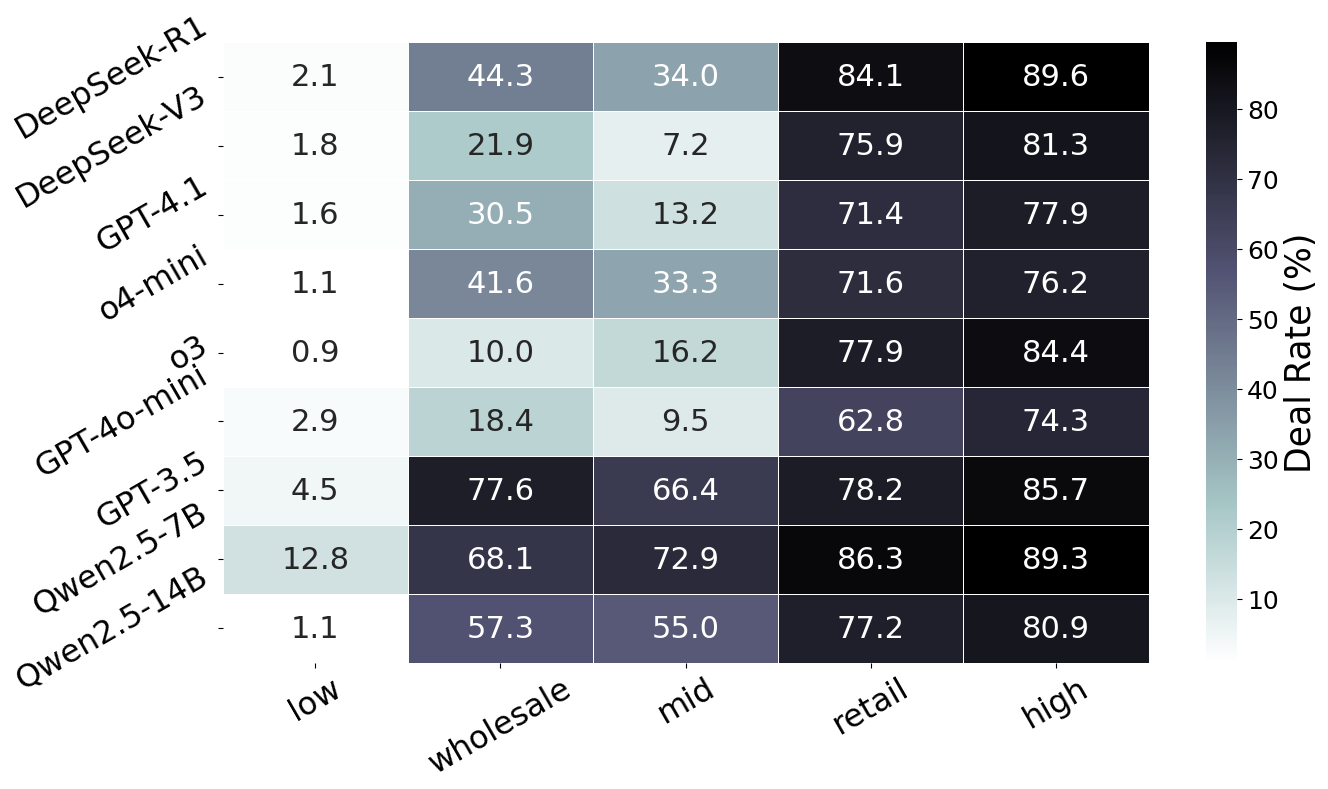

Deal Rate Heatmap created successfully.
All figures created successfully.


In [28]:
import seaborn as sns
def plot_deal_rate_heatmap(comprehensive_df, save_dir='../figures/seller_model_performance'):
    """
    绘制成交率热力图
    
    Parameters:
    -----------
    comprehensive_df : pandas.DataFrame
        包含所有模型和预算类型数据的DataFrame
    save_dir : str
        图片保存目录
    """
    # 模型名称映射
    display_names = {
        "deepseek-reasoner": "DeepSeek-R1",
        "deepseek-chat": "DeepSeek-V3",
        "gpt-4o-mini": "GPT-4o-mini",
        "gpt-3.5-turbo": "GPT-3.5",
        "qwen2.5-7b-instruct": "Qwen2.5-7B",
        "qwen2.5-14b-instruct": "Qwen2.5-14B",
        "gpt-4.1": "GPT-4.1"
    }
    
    # 设定模型显示顺序
    model_order = [
        "DeepSeek-R1",
        "DeepSeek-V3", 
        "GPT-4.1",
        "o4-mini",
        "o3",
        "GPT-4o-mini",
        "GPT-3.5",
        "Qwen2.5-7B",
        "Qwen2.5-14B"
    ]
    
    # 预算类型顺序
    budget_order = ['low', 'wholesale', 'mid', 'retail', 'high']
    
    # 从comprehensive_df中提取数据
    # 只选择非'Overall'的预算类型数据
    budget_data = comprehensive_df[comprehensive_df['Budget'] != 'Overall'].copy()
    
    # 替换模型名称
    budget_data['Model'] = budget_data['Model'].map(display_names).fillna(budget_data['Model'])
    
    # 创建透视表，行为模型，列为预算类型，值为成交率
    pivot_df = budget_data.pivot_table(
        index='Model',
        columns='Budget',
        values='Deal_Rate',
        aggfunc='mean'
    ) * 100  # 转换为百分比
    
    # 重新排序列和行
    pivot_df = pivot_df.reindex(columns=budget_order)
    pivot_df = pivot_df.reindex(model_order)
    
    # 设置图形大小
    plt.figure(figsize=(14, 8))
    
    # 创建热力图
    ax = sns.heatmap(pivot_df, 
                     cmap="bone_r",
                     cbar_kws={'label': 'Deal Rate (%)'},
                     linewidths=0.5, 
                     annot=True, 
                     fmt=".1f",
                     annot_kws={"fontsize": 22})
    
    # 设置颜色条样式
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label('Deal Rate (%)', fontsize=25)
    
    # 调整刻度标签样式
    plt.xticks(rotation=30, fontsize=23)
    plt.yticks(rotation=30, fontsize=23)
    plt.xlabel('', fontsize=23)
    plt.ylabel('', fontsize=23)
    
    # 保存图片
    os.makedirs(save_dir, exist_ok=True)
    file_path = f'{save_dir}/deal_rate_heatmap.svg'
    plt.tight_layout()
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("Deal Rate Heatmap created successfully.")

def main():
    # 首先运行数据分析代码获取必要的DataFrame
    print("Analyzing deal rates and profits...")
    stats, budget_types = analyze_deal_rates_and_profits()
    
    print("Preparing analysis data...")
    deal_rate_df, profit_df, comprehensive_df = prepare_analysis_data(stats, budget_types)
    
    # 绘制热力图
    plot_deal_rate_heatmap(comprehensive_df)
    print("All figures created successfully.")

if __name__ == "__main__":
    main()

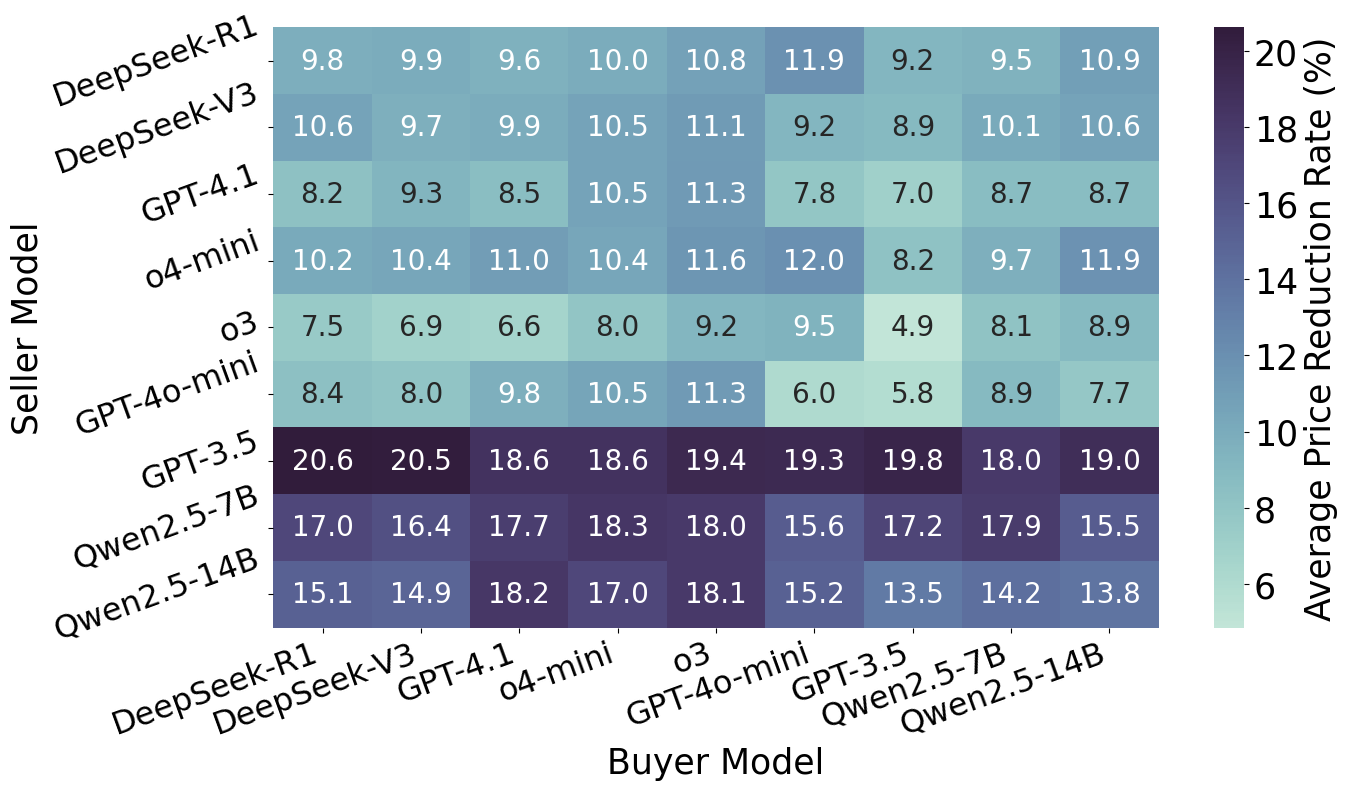


Number of samples in each cell:
             DeepSeek-R1  DeepSeek-V3  GPT-4.1  o4-mini     o3  GPT-4o-mini  \
DeepSeek-R1        250.0        250.0    291.0    282.0  250.0        250.0   
DeepSeek-V3        250.0        250.0    396.0    327.0  250.0        250.0   
GPT-4.1            284.0        364.0    490.0    382.0  250.0        375.0   
o4-mini            281.0        349.0    429.0    348.0  250.0        399.0   
o3                 250.0        249.0    250.0    249.0  250.0        250.0   
GPT-4o-mini        250.0        250.0    489.0    362.0  249.0        250.0   
GPT-3.5            250.0        250.0    484.0    392.0  250.0        250.0   
Qwen2.5-7B         250.0        250.0    489.0    365.0  250.0        254.0   
Qwen2.5-14B        250.0        250.0    486.0    388.0  250.0        250.0   

             GPT-3.5  Qwen2.5-7B  Qwen2.5-14B  
DeepSeek-R1    250.0       262.0        260.0  
DeepSeek-V3    250.0       257.0        254.0  
GPT-4.1        376.0       371.0

In [29]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def rename_model(model_name):
    model_name = model_name.replace("seller_", "")
    model_name = model_name.replace("deepseek-reasoner", "DeepSeek-R1")
    model_name = model_name.replace("deepseek-chat", "DeepSeek-V3")
    model_name = model_name.replace("gpt-4o-mini", "GPT-4o-mini")
    model_name = model_name.replace("gpt-3.5-turbo", "GPT-3.5")
    model_name = model_name.replace("qwen2.5-14b-instruct", "Qwen2.5-14B")
    model_name = model_name.replace("qwen2.5-7b-instruct", "Qwen2.5-7B")
    model_name = model_name.replace("gpt-4.1", "GPT-4.1")
    return model_name

# 定义期望的模型顺序
desired_order = [
    "deepseek-reasoner",
    "deepseek-chat",
    "gpt-4.1",
    "o4-mini",
    "o3",
    "gpt-4o-mini",
    "gpt-3.5-turbo",
    "qwen2.5-7b-instruct",
    "qwen2.5-14b-instruct"
]

# 基本目录
base_dir = "../results"

# 获取所有seller模型
seller_models = []
for item in os.listdir(base_dir):
    if os.path.isdir(os.path.join(base_dir, item)) and item.startswith("seller_"):
        seller_models.append(item)

# 获取buyer模型（去掉seller_前缀）
buyer_models = [model.replace("seller_", "") for model in seller_models]

# 按照desired_order重新排序
ordered_seller_models = []
ordered_buyer_models = []

for model_key in desired_order:
    for seller_model in seller_models:
        clean_name = seller_model.replace("seller_", "")
        if model_key.lower() in clean_name.lower():
            ordered_seller_models.append(seller_model)
            ordered_buyer_models.append(clean_name)

# 清理模型名称
seller_labels = [rename_model(model) for model in ordered_seller_models]
buyer_labels = [rename_model(model) for model in ordered_buyer_models]

# 创建矩阵存储bargaining rate数据
n_models = len(ordered_seller_models)
bargain_matrix = np.zeros((n_models, n_models))
count_matrix = np.zeros((n_models, n_models))

# 遍历所有数据文件并计算bargaining rate
for i, seller_model in enumerate(ordered_seller_models):
    for j, buyer_model in enumerate(ordered_buyer_models):
        model_dir = os.path.join(base_dir, seller_model, buyer_model)
        
        if not os.path.exists(model_dir):
            continue
        
        for product_dir in os.listdir(model_dir):
            if not product_dir.startswith("product_"):
                continue
            
            for budget_type in ['low', 'wholesale', 'mid', 'retail', 'high']:
                budget_dir = os.path.join(model_dir, product_dir, f"budget_{budget_type}")
                if not os.path.exists(budget_dir):
                    continue
                
                for file in os.listdir(budget_dir):
                    if file.endswith('.json'):
                        json_file = os.path.join(budget_dir, file)
                        try:
                            with open(json_file, 'r', encoding='utf-8') as f:
                                data = json.load(f)
                            
                            if "bargaining_rate" in data:
                                bargain_rate = data["bargaining_rate"] * 100  # 转换为百分比
                                bargain_matrix[i, j] += bargain_rate
                                count_matrix[i, j] += 1
                                
                        except Exception as e:
                            print(f"Error processing {json_file}: {e}")

# 计算平均bargaining rate
avg_bargain_matrix = np.zeros_like(bargain_matrix)
for i in range(n_models):
    for j in range(n_models):
        if count_matrix[i, j] > 0:
            avg_bargain_matrix[i, j] = bargain_matrix[i, j] / count_matrix[i, j]
        else:
            avg_bargain_matrix[i, j] = np.nan  # 使用NaN表示空单元格

# 创建热图
plt.figure(figsize=(14, 8))
ax = plt.gca()

# 创建自定义的cubehelix调色板
custom_cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# 生成热图，seller作为行（y轴），buyer作为列（x轴）
sns.heatmap(avg_bargain_matrix, annot=True, fmt=".1f", 
            cmap=custom_cmap,
            xticklabels=buyer_labels, yticklabels=seller_labels,
            cbar_kws={'label': 'Average Price Reduction Rate (%)'},
            annot_kws={"size": 20})

# 设置标签
plt.xlabel('Buyer Model', fontsize=25)
plt.ylabel('Seller Model', fontsize=25)

# 调整字体大小
plt.xticks(rotation=20, ha='right', fontsize=23)
plt.yticks(rotation=20, fontsize=23)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Average Price Reduction Rate (%)', fontsize=25)

# 保存和显示
save_dir = '../figures'
os.makedirs(save_dir, exist_ok=True)
plt.tight_layout()
plt.savefig(f'{save_dir}/negotiation_deal_rate_heatmap.svg', dpi=300)
plt.show()

# 打印一些统计信息
print("\nNumber of samples in each cell:")
print(pd.DataFrame(count_matrix, index=seller_labels, columns=buyer_labels))